In [2]:
pwd()
using Pkg; Pkg.activate("../../FermiCG/")
using FermiCG, NPZ, JLD2
using Plots

readdir()

  Activating project at `~/code/FermiCG`


12-element Vector{String}:
 ".ipynb_checkpoints"
 ".scf.py.swp"
 "Cact.molden"
 "Untitled.ipynb"
 "geometry.xyz"
 "integrals_h0.npy"
 "integrals_h1.npy"
 "integrals_h2.npy"
 "mo_coeffs_act.npy"
 "mo_coeffs_doc.npy"
 "overlap_mat.npy"
 "scf.py"

In [24]:
#load integrals from disk
ints = InCoreInts(
    npzread("integrals_h0.npy"), 
    npzread("integrals_h1.npy"), 
    npzread("integrals_h2.npy") 
);
C = npzread("mo_coeffs_act.npy")
S = npzread("overlap_mat.npy");
D = npzread("density_mat.npy");


 Laplacian Eigenvalues
    1  -0.00000000
    2   0.20965414
    3   0.57003540
    4   0.60015130


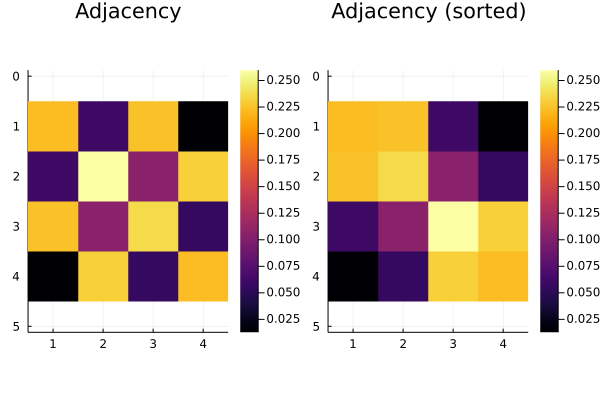

In [69]:
using LinearAlgebra, Printf
using Clustering
using SpectralClustering
using Random
Random.seed!(2)

function cluster_orbitals(A, n_clusters)
    """
    A is adjacency matrix
    """
    
    L = Diagonal([sum(A[i,:]) for i in 1:size(A,1)]) - A;
    F = eigen(L);
    perm = sortperm(F.values, by=abs)
    F.values .= F.values[perm]
    F.vectors .= F.vectors[:,perm]

    print(" Laplacian Eigenvalues\n")
    for (fi_idx, fi) in enumerate(F.values)
        @printf(" %4i %12.8f\n", fi_idx, fi)
    end
    
    p1 = plot(F.values)
    
    A = abs.(F.vectors[:,1:n_clusters]*F.vectors[:,1:n_clusters]')
    p2 = heatmap(abs.(A), aspect_ratio=:equal, title="Projector", yflip = true)
    
    clustering = clusterize(KMeansClusterizer(n_clusters), A).assignments;

    perm = sortperm(clustering)
    p3 = heatmap(abs.(A[perm,perm]), aspect_ratio=:equal, title="Projector", yflip = true)

    clusters = [ [] for i in 1:n_clusters]
    for (idx,i) in enumerate(clustering)
        push!(clusters[i],idx)
    end

    plot(p1, p2, p3, layout = @layout [a; b c])

    return perm, clusters
end

n_clusters = 2
adjacency = abs.(C'*D*C)
perm, cluster_list = cluster_orbitals(adjacency, n_clusters)

    
p1 = heatmap(adjacency, aspect_ratio=:equal, title="Adjacency", yflip = true) 
p2 = heatmap(adjacency[perm, perm], aspect_ratio=:equal, title="Adjacency (sorted)", yflip = true) 


plot(p1, p2, layout = @layout [a b])


In [70]:
# define clusters
clusters = [Cluster(i,collect(cluster_list[i])) for i = 1:length(cluster_list)]
init_fspace = [ (1,1) for i in 1:n_clusters]
display(clusters)


2-element Vector{Cluster}:
 Cluster(1, [1, 3])
 Cluster(2, [2, 4])

In [71]:
rdm1 = C'*D*C

e_cmf, U, Da, Db  = FermiCG.cmf_oo(ints, clusters, init_fspace, rdm1, rdm1,
                                        max_iter_oo=50, verbose=0, gconv=1e-6, method="bfgs");


 ooCMF Iter:    1 Total= -154.920462014735 Active=  -3.264463927180 G=     2.96e-01
 ooCMF Iter:    2 Total= -154.949213535592 Active=  -3.293215448037 G=     3.81e-03
 ooCMF Iter:    3 Total= -154.949217854516 Active=  -3.293219766961 G=     9.99e-04
 ooCMF Iter:    4 Total= -154.949218179634 Active=  -3.293220092078 G=     1.44e-04
 ooCMF Iter:    5 Total= -154.949218232331 Active=  -3.293220144775 G=     6.47e-06
 ooCMF Iter:    6 Total= -154.949218232371 Active=  -3.293220144816 G=     6.43e-06


 * Status: success

 * Candidate solution
    Final objective value:     -1.549492e+02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.62e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.18e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.18e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.70e-13 ≰ 0.0e+00
    |g(x)|                 = 5.90e-09 ≤ 1.0e-06

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    6
    f(x) calls:    17
    ∇f(x) calls:   17


*ooCMF Iter:    7 Total= -154.949218232413 Active=  -3.293220144858 G=     8.10e-09
*ooCMF -154.94921823 


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/nmayhall/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [72]:
# FermiCG.pyscf_write_molden(mol,C_cmf,filename="benzene_10mer_cmf.molden");
ints_cmf = FermiCG.orbital_rotation(ints,U);

In [74]:
max_roots = 100

#
# Build Cluster basis
cluster_bases = FermiCG.compute_cluster_eigenbasis(ints, clusters, verbose=0, max_roots=max_roots,
        init_fspace=init_fspace, rdm1a=Da, rdm1b=Db);
#
# Build ClusteredOperator
clustered_ham = FermiCG.extract_ClusteredTerms(ints, clusters);

#
# Build Cluster Operators
cluster_ops = FermiCG.compute_cluster_ops(cluster_bases, ints);

#
# Add cmf hamiltonians for doing MP-style PT2 
FermiCG.add_cmf_operators!(cluster_ops, cluster_bases, ints, Da, Db, verbose=0);


 Remove duplicates
 Number of terms reduced from    62 to    34


In [77]:
nroots = 1
ci_vector = FermiCG.TPSCIstate(clusters, FermiCG.FockConfig(init_fspace), R=nroots);
display(ci_vector)

 --------------------------------------------------
 ---------- Fockspaces in state ------: Dim =     1  
 ----------                root ------:     =     1  
 --------------------------------------------------
 Printing contributions greater than: 0.001000
 Weight              # Configs           Fock space(α,β)...  
 -------             ---------           ----------          
 --------------------------------------------------


In [78]:
e0, v0 = FermiCG.tpsci_ci(ci_vector, cluster_ops, clustered_ham,
                            thresh_cipsi=1e-3, # Threshold for adding to P-space
                            thresh_foi=1e-5,    # Threshold for keeping terms when defining FOIS    
                            thresh_asci=1e-2,     # Threshold of P-space configs to search from
                            max_iter=10,
                            matvec=3);

 ci_vector     : (1, 1)
 thresh_cipsi  : 0.001
 thresh_foi    : 1.0e-5
 thresh_asci   : 0.01
 thresh_var    : -1.0
 max_iter      : 10
 conv_thresh   : 0.0001
 nbody         : 4
 incremental   : true
 ci_conv       : 1.0e-5
 ci_max_iter   : 50
 ci_max_ss_vecs: 12
 davidson      : false
 max_mem_ci    : 20.0
 matvec        : 3


     Selected CI Iteration:    1 epsilon:   0.00100000
 Memory needed to hold full CI matrix:   0.00000001 (Gb)

 |== Tensor Product State CI =======================================
 Hamiltonian matrix dimension =     1: 
 Build full Hamiltonian matrix with dimension:       0.263865 seconds (759.40 k allocations: 40.659 MiB, 99.73% compilation time)
 Diagonalize: 
                                      0.000005 seconds (4 allocations: 224 bytes)
 Compute S2 expectation values:                      0.172261 seconds (193.44 k allocations: 10.765 MiB, 99.69% compilation time)
  Root       Energy           S2
     1  -3.26446390   0.00000000
 ========================

In [80]:
e0[1]+ints.h0

-154.95333862914796